In [3621]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from random import randint

In [3622]:
# Define number of bacteria for each images
n_bact = {
   "0004" : [23],
   "0008" : [47, 48],
   "0011" : [23, 24, 25],
   "0013" : [16],
   "0015" : [13],
   "0016" : [15],
   "0017" : [15, 16, 17],
   "0018" : [18, 19],
   "0018 copy" : [10],
   "0020" : [25],
}

In [3623]:
def markers_watershed(img, sure_fg, full=False):
   # Compute background area
   img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
   _, thresh = cv.threshold(img_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
   kernel = np.ones((3,3),np.uint8)
   sure_bg = cv.dilate(thresh, kernel, iterations=2) if full else cv.erode(thresh, kernel, iterations=3) 

   # Finding unknown region
   unknown = cv.subtract(sure_bg, sure_fg)

   # Marker labelling
   _, markers = cv.connectedComponents(sure_fg)
   markers = markers + 1
   markers[unknown==255] = 0

   return cv.watershed(img, markers)

In [3624]:
def display_all(img, markers, sure_fg, bin_img, fill_markers=False):
   res = img.copy()
   
   # Add watershed colored markers in the images
   if fill_markers:
      for i in range(2, markers.max() + 1):
         res[markers == i] = [randint(0,256), randint(0,256), randint(0,256)]
   else:
      res[markers == -1] = [255,255,0]

   # Plot all the images
   _, axes = plt.subplots(1, 4, figsize=(16, 5))
   [axi.set_axis_off() for axi in axes]
   axes[0].imshow(img)
   axes[1].imshow(bin_img, cmap="gray")
   axes[2].imshow(sure_fg, cmap="gray")
   axes[3].imshow(res)
   plt.axis("off")
   plt.show()

In [3625]:
def b_hand(img, threshold=80):
   img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
   img_gray = cv.GaussianBlur(img_gray, (5,5), 0)
   _, img_th = cv.threshold(img_gray, threshold, 255, cv.THRESH_BINARY_INV)
   return img_th

In [3626]:
def b_ostu(img):
   img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
   _, img_th = cv.threshold(img_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
   return img_th

In [3627]:
def b_kmeans(img):
   K = 3
   Z = np.float32(img.reshape((-1,3)))
   criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

   # Apply KMeans
   _, label, center = cv.kmeans(Z, K, None, criteria, 10, cv.KMEANS_PP_CENTERS)

   center = np.uint8(center)

   # Keep only the min and max center
   ctr_mean = {i: np.mean(center[i]) for i in range(K)}
   sorted_i = sorted(ctr_mean.keys(), key=lambda item: ctr_mean[item], reverse=True)
   center[sorted_i[1:-1]] = center[sorted_i[0]]

   # Recreate the image
   res = center[label.flatten()]
   img_res = res.reshape((img.shape))

   # Binarize the image with Otsu
   img_gray = cv.cvtColor(img_res, cv.COLOR_RGB2GRAY)
   img_gray = cv.GaussianBlur(img_gray, (5, 5), 0)
   _, bin_img = cv.threshold(img_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
   
   return bin_img

In [3628]:
def erosion(img, i=4):
   kernel = np.ones((3, 3), np.uint8)
   return cv.erode(img, kernel, iterations=i)

In [3629]:
def reconstruct(img, markers):
   for i in range(1, markers.max() + 1):
      if len(set(img[markers==i])) == 1:
         img[markers == i] = 255

def muliple_erosion(img, i1=(0)):
   res_img = img.copy()

   for e in i1:
      _, markers = cv.connectedComponents(res_img)
      res_img = erosion(res_img, e)

      # Recreate potential deleted bacteria
      reconstruct(res_img, markers)
   
   return res_img

In [3630]:
def dist_trsf(img, threshold=0.5):
   dist_transform = cv.distanceTransform(img, cv.DIST_L2, 3)
   _, sure_fg = cv.threshold(dist_transform, threshold * dist_transform.max(), 255, 0)
   return np.uint8(sure_fg)

In [3631]:
def verification(img):  
   # Get all sorted list of all the white components
   _, markers = cv.connectedComponents(img)
   cmpt_size = {i : img[markers==i].size for i in range(1, markers.max() + 1)}
   sorted_i = sorted(cmpt_size.keys(), key=lambda item: cmpt_size[item], reverse=True)

   # Look for potential group of bacteria
   suspect = 0
   for i in range(3):
      if (cmpt_size[sorted_i[i]] - cmpt_size[sorted_i[i + 1]]) > 200:
         suspect = i + 1

   # Apply distance transfrom to the suspect
   img_2 = dist_trsf(img)
   img_3 = img.copy()
   for i in sorted_i[:suspect]:
      img_3[markers==i] = img_2[markers==i]
   
   return img_3

In [3632]:
def run(n_bact, display=True):
   res = 0
   for file in n_bact:
      img_bgr = cv.imread(f"./images/Candida.albicans_{file}.tif", cv.COLOR_BGR2RGB)
      img = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
      
      bin_img = b_kmeans(img)

      sure_fg = erosion(bin_img, 2)

      sure_fg = muliple_erosion(sure_fg, (3, 3, 4))

      sure_fg = verification(sure_fg)
      
      markers = markers_watershed(img, sure_fg)

      print(f"Candida.albicans_{file} : Number {n_bact[file]} - Found {markers.max() - 1}")
      if display: display_all(img, markers, sure_fg, bin_img, True)

      res += 1 if (markers.max() - 1 in n_bact[file]) else 0
      
   print(f"Accuracy: {round(res / len(n_bact) * 100, 2)}%")

Candida.albicans_0004 : Number [23] - Found 23


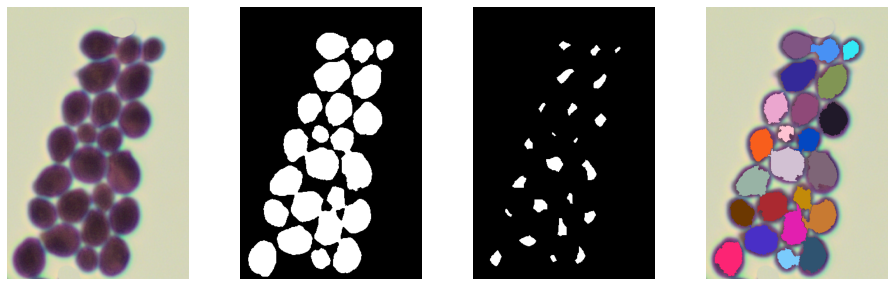

Candida.albicans_0008 : Number [47, 48] - Found 48


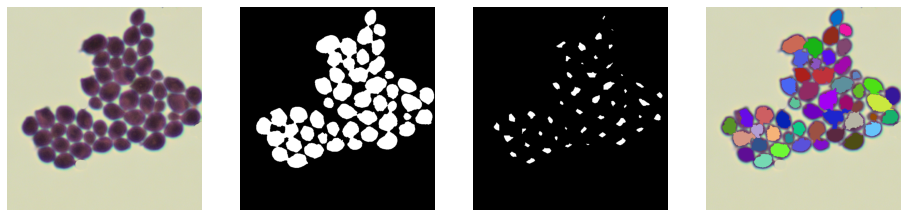

Candida.albicans_0011 : Number [23, 24, 25] - Found 24


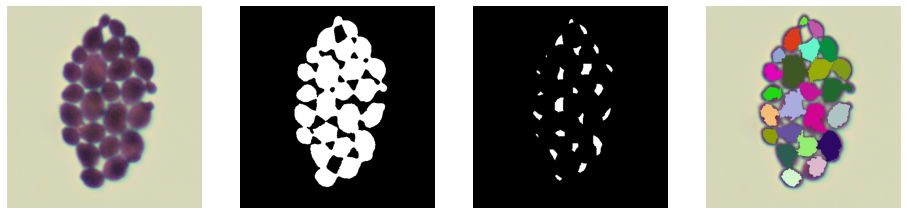

Candida.albicans_0013 : Number [16] - Found 16


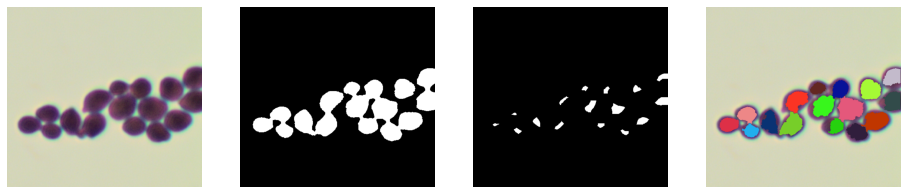

Candida.albicans_0015 : Number [13] - Found 13


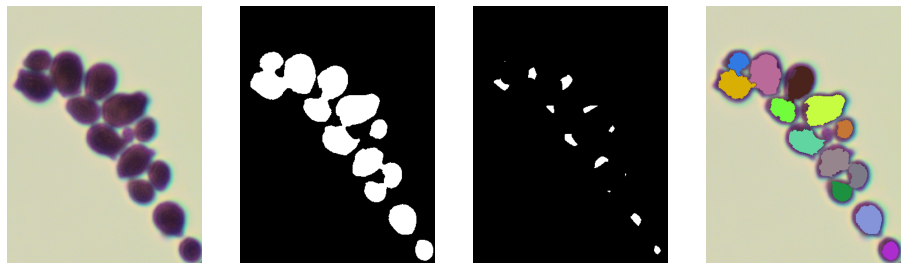

Candida.albicans_0016 : Number [15] - Found 15


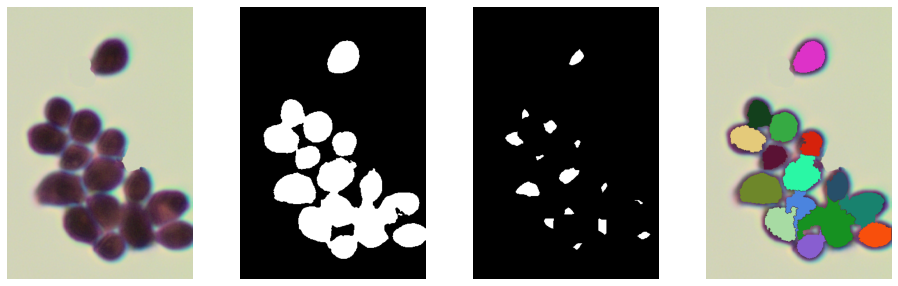

Candida.albicans_0017 : Number [15, 16, 17] - Found 17


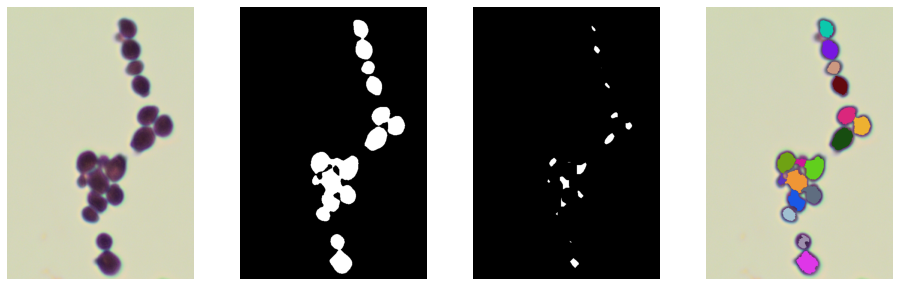

Candida.albicans_0018 : Number [18, 19] - Found 19


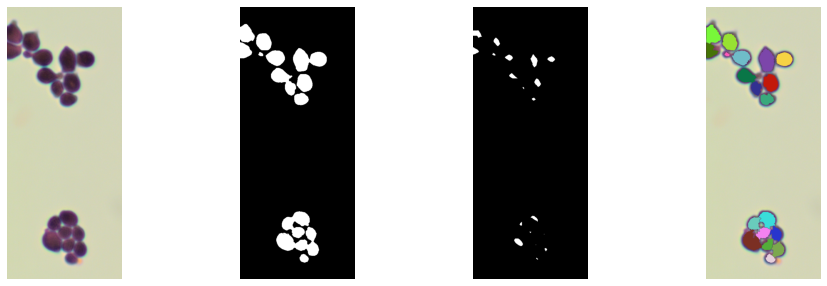

Candida.albicans_0018 copy : Number [10] - Found 10


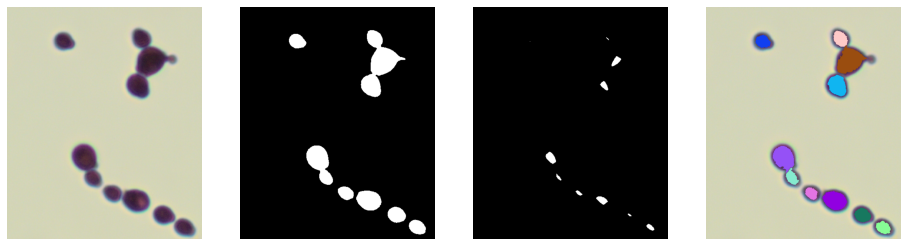

Candida.albicans_0020 : Number [25] - Found 25


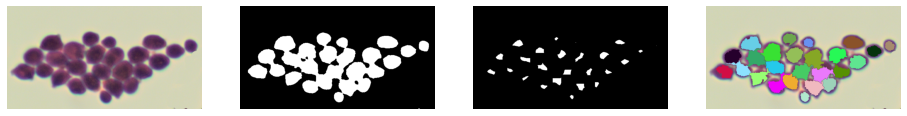

Accuracy: 100.0%


In [3633]:
run(n_bact, True)